# Ring filter

## Calculations

For a ring resonator we need to define:

Optical parameters:

- coupling coefficient: will define resonance extinction ratio for a particular ring loss.
- Free spectral range.

Electrical parameters:

- VpiL
- Resistance

In [1]:
try:
  import google.colab
  is_running_on_colab = True
  !pip install gdsfactory gplugins[tidy3d,sax] > /dev/null
  !apt install python3-gmsh gmsh > /dev/null
  
except ImportError:
  is_running_on_colab = False

2023-11-25 15:34:48.225 | INFO     | gdsfactory.technology.layer_views:__init__:810 - Importing LayerViews from YAML file: 'C:\\Users\\s3923133\\AppData\\Local\\miniconda3\\Lib\\site-packages\\gdsfactory\\generic_tech\\layer_views.yaml'.
2023-11-25 15:34:48.245 | INFO     | gdsfactory.pdk:activate:341 - 'generic' PDK is now active


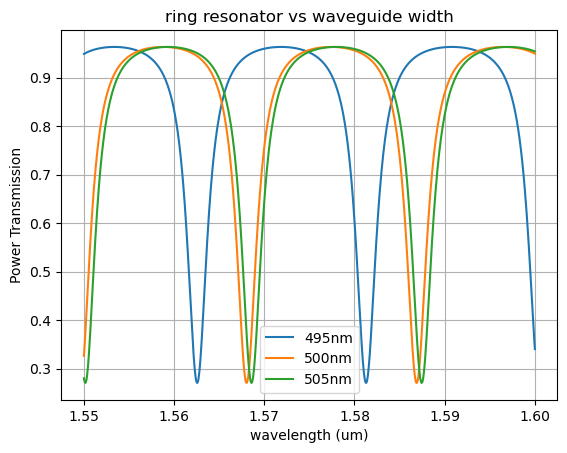

In [2]:
import numpy as np
import gdsfactory as gf
from gdsfactory.generic_tech import get_generic_pdk

gf.config.rich_output()
gf.CONF.display_type = 'klayout' # for plotting in Colab notebook
PDK = get_generic_pdk()
PDK.activate()


def ring(
    wl: np.ndarray,
    wl0: float,
    neff: float,
    ng: float,
    ring_length: float,
    coupling: float,
    loss: float,
) -> np.ndarray:
    """Returns Frequency Domain Response of an all pass filter.

    Args:
        wl: wavelength in  um.
        wl0: center wavelength at which neff and ng are defined.
        neff: effective index.
        ng: group index.
        ring_length: in um.
        coupling: coupling coefficient.
        loss: dB/um.
    """
    transmission = 1 - coupling
    neff_wl = (
        neff + (wl0 - wl) * (ng - neff) / wl0
    )  # we expect a linear behavior with respect to wavelength
    out = np.sqrt(transmission) - 10 ** (-loss * ring_length / 20.0) * np.exp(
        2j * np.pi * neff_wl * ring_length / wl
    )
    out /= 1 - np.sqrt(transmission) * 10 ** (-loss * ring_length / 20.0) * np.exp(
        2j * np.pi * neff_wl * ring_length / wl
    )
    return abs(out) ** 2


if __name__ == "__main__":
    import matplotlib.pyplot as plt

    loss = 0.03  # [dB/μm] (alpha) waveguide loss
    neff = 2.46  # Effective index of the waveguides
    wl0 = 1.55  # [μm] the wavelength at which neff and ng are defined
    radius = 5
    ring_length = 2 * np.pi * radius  # [μm] Length of the ring
    coupling = 0.5  # [] coupling of the coupler
    wl = np.linspace(1.5, 1.6, 1000)  # [μm] Wavelengths to sweep over
    wl = np.linspace(1.55, 1.60, 1000)  # [μm] Wavelengths to sweep over
    ngs = [4.182551, 4.169563, 4.172917]
    thicknesses = [210, 220, 230]

    # widths = np.array([0.4, 0.45, 0.5, 0.55, 0.6])
    # ngs = np.array([4.38215238, 4.27254985, 4.16956338, 4.13283219, 4.05791982])

    widths = np.array([0.495, 0.5, 0.505])
    neffs = np.array([2.40197253, 2.46586378, 2.46731758])
    ng = 4.2  # Group index of the waveguides

    for width, neff in zip(widths, neffs):
        p = ring(
            wl=wl,
            wl0=wl0,
            neff=neff,
            ng=ng,
            ring_length=ring_length,
            coupling=coupling,
            loss=loss,
        )
        plt.plot(wl, p, label=f"{int(width*1e3)}nm")

    plt.title("ring resonator vs waveguide width")
    plt.xlabel("wavelength (um)")
    plt.ylabel("Power Transmission")
    plt.grid()
    plt.legend()
    plt.show()

## Layout

gdsfactory easily enables you to layout Component with as many levels of hierarchy as you need.

A `Component` is a canvas where we can add polygons, references to other components or ports.

Lets add two references in a component.

You can install `pip install gdsfactory` for better visualization


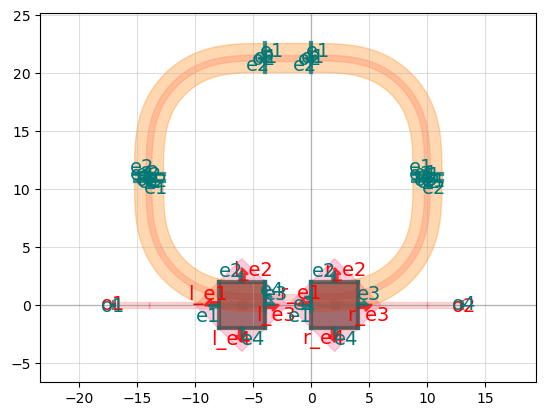

In [3]:
from typing import Optional

import toolz
from omegaconf import OmegaConf

from gdsfactory.component import Component
from gdsfactory.components.bend_euler import bend_euler
from gdsfactory.components.coupler90 import coupler90 as coupler90function
from gdsfactory.components.coupler_straight import (
    coupler_straight as coupler_straight_function,
)
from gdsfactory.components.straight import straight
from gdsfactory.cross_section import strip
from gdsfactory.snap import assert_on_2nm_grid
from gdsfactory.typings import ComponentSpec, CrossSectionSpec

import gdsfactory as gf

c = gf.components.ring_single_heater(gap=0.2, radius=10, length_x=4)
c.plot()

In [ ]:
scene = c.to_3d()
scene.show()

Lets define a ring function that also accepts other component specs for the subcomponents (straight, coupler, bend)

In [ ]:
ring = gf.components.ring_single_heater(gap=0.2, radius=10, length_x=4, via_stack_offset=(2, 0))
ring_with_grating_couplers = gf.routing.add_fiber_array(ring)
ring_with_grating_couplers.plot()

In [ ]:
port_names = ["l_e1", "r_e3"]
port_names = ["l_e4", "r_e4"]
c = gf.routing.add_pads_top(ring, port_names = port_names, )
c = gf.routing.add_fiber_array(c)
c.plot()
c.show()

## Top reticle assembly

Once you have your components and circuits defined, you can add them into a top reticle Component for fabrication.

You need to consider:

- what design variations do you want to include in the mask? You need to define your Design Of Experiment or DOE
- obey DRC (Design rule checking) foundry rules for manufacturability. Foundry usually provides those rules for each layer (min width, min space, min density, max density)
- make sure you will be able to test te devices after fabrication. Obey DFT (design for testing) rules. For example, if your test setup works only for fiber array, what is the fiber array spacing (127 or 250um?)
- if you plan to package your device, make sure you follow your packaging guidelines from your packaging house (min pad size, min pad pitch, max number of rows for wire bonding ...)

In [ ]:
nm = 1e-3
ring_te = toolz.compose(gf.routing.add_fiber_array, gf.components.ring_single)

gaps = [210 * nm, 220 * nm, 230 * nm]
rings = gf.grid([ring_te(gap=gap, info=dict(doe='rings_passive')) for gap in gaps])


rings_heater = [
    gf.components.ring_single_heater(gap=0.2, radius=10, length_x=4, via_stack_offset=(2,0)) for gap in gaps
]
rings_with_pads = [
    gf.routing.add_fiber_array(gf.routing.add_pads_top(ring, port_names=port_names), decorator=gf.labels.add_label_json)
    for ring in rings_heater
]


@gf.cell
def reticle(size=(1000, 1000)):
    c = gf.Component()
    r = c << rings
    m = c << gf.pack(rings_with_pads)[0]
    m.xmin = r.xmax + 10
    m.ymin = r.ymin
    c << gf.components.seal_ring(c.bbox)
    return c


m = reticle()
gf.remove_from_cache(m)
m.show()
m.plot()

In [ ]:
nm = 1e-3
ring_te = toolz.compose(gf.routing.add_fiber_array, gf.components.ring_single)
rings = gf.grid([ring_te(radius=r, decorator=gf.labels.add_label_json) for r in [10, 20, 50]])



@gf.cell
def reticle(size=(1000, 1000)):
    c = gf.Component()
    r = c << rings
    m = c << gf.components.pack_doe(
        gf.components.mzi,
        settings=dict(delta_length=[100, 200]),
        function=gf.routing.add_fiber_single,
        
    )
    m.xmin = r.xmax + 10
    m.ymin = r.ymin
    c << gf.components.seal_ring(c.bbox)
    return c


m = reticle()
gf.remove_from_cache(m)
m.show()
m.plot()

In [ ]:
gdspath = m.write_gds(gdspath="mask.gds")

You can also save the labels for automatic testing and turn them into a test sequence.

In [ ]:
import pandas as pd

csvpath = gf.labels.write_labels.write_labels_gdstk(
    gdspath, debug=True, prefixes=["{"], layer_label="TEXT"
)
df = pd.read_csv(csvpath)
df

As you can see there are 6 devices with optical and electrical ports.

You can turn each label into a test manifest [CSV file](https://docs.google.com/spreadsheets/d/1845m-XZM8tZ1tNd8GIvAaq7ZE-iha00XNWa0XrEOabc/edit#gid=138229318) to interface with your lab instrumentation functions.

Each measurement will use a different measurement procedure and settings measurement_settings

The default measurement settings for each functions can also be defined in a separate CSV file and easily editable with Excel or LibreOffice.

In [ ]:
from gdsfactory.labels.write_test_manifest import write_test_manifest

dm = write_test_manifest(csvpath)
dm